In [ ]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from keras.datasets import fashion_mnist
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

basepath = '/content/drive/Shareddrives/ECEN_758_Project'
traindata = pd.read_csv(basepath + '/blob/fashion-mnist_train.csv')
testdata = pd.read_csv(basepath + '/blob/fashion-mnist_test.csv')

Mounted at /content/drive


In [ ]:
def getlabels(data):

  labelsarray = np.unique(data['label'])
  typesarray = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  labels_info = {}
  for i in labelsarray:
    labels_info.update({i: typesarray[i]})

  labels = data['label']

  return labels, labels_info

In [ ]:
train_labels, labels_info = getlabels(traindata)
test_labels, _ = getlabels(testdata)

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
from sklearn.model_selection import train_test_split
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
y_train_clf_encoded = tf.one_hot(y_train_clf, depth = 10)
y_val_clf_encoded = tf.one_hot(y_val_clf, depth = 10)
y_test_clf_encoded = tf.one_hot(y_test, depth = 10)

In [ ]:
X_train_rf = X_train_clf.reshape(len(X_train_clf), 784)
X_val_rf = X_val_clf.reshape(len(X_val_clf), 784)
X_test_rf = x_test.reshape(len(x_test), 784)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Xception

In [ ]:
# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip("vertical"),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1),
#     ]
# )

In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))
# x = data_augmentation(inputs)
x = inputs

x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    residual = x

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    residual = tf.keras.layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = tf.keras.layers.add([x, residual])

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
clf1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-10,
    amsgrad=False,
    weight_decay=None
)

In [ ]:
callbacks_list = [
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.001,
        patience=5,
        verbose=0,
        mode="auto",
        min_delta=0.00001,
        cooldown=0,
        min_lr=0,
    ),
    EarlyStopping(
        monitor="val_accuracy",
        patience=25,
    ),
    ModelCheckpoint(
        filepath="/content/drive/Shareddrives/ECEN_758_Project/xception_stable_III.h5",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [ ]:
clf1.compile(loss="CategoricalCrossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "Precision", "Recall"])
history_clf1 = clf1.fit(
    X_train_clf,
    y_train_clf_encoded,
    epochs=250,
    batch_size=64,
    callbacks=callbacks_list,
    validation_data=(X_val_clf, y_val_clf_encoded)
)

Epoch 1/250
750/750 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.8079 - precision: 0.8517 - recall: 0.7706

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


750/750 [==============================] - 78s 61ms/step - loss: 0.5499 - accuracy: 0.8079 - precision: 0.8517 - recall: 0.7706 - val_loss: 0.4164 - val_accuracy: 0.8522 - val_precision: 0.8801 - val_recall: 0.8292 - lr: 0.0010
Epoch 2/250
750/750 [==============================] - 42s 56ms/step - loss: 0.3911 - accuracy: 0.8638 - precision: 0.8876 - recall: 0.8439 - val_loss: 0.3898 - val_accuracy: 0.8637 - val_precision: 0.8817 - val_recall: 0.8506 - lr: 0.0010
Epoch 3/250
750/750 [==============================] - 45s 60ms/step - loss: 0.3396 - accuracy: 0.8833 - precision: 0.9024 - recall: 0.8667 - val_loss: 0.3429 - val_accuracy: 0.8833 - val_precision: 0.9045 - val_recall: 0.8622 - lr: 0.0010
Epoch 4/250
750/750 [==============================] - 36s 48ms/step - loss: 0.3098 - accuracy: 0.8939 - precision: 0.9101 - recall: 0.8789 - val_loss: 0.3582 - val_accuracy: 0.8816 - val_precision: 0.8965 - val_recall: 0.8694 - lr: 0.0010
Epoch 5/250
750/750 [==============================]

In [ ]:
clf1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 24, 24, 32)           800       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 24, 24, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 24, 24, 32)           0         ['batch_normalization[0][0

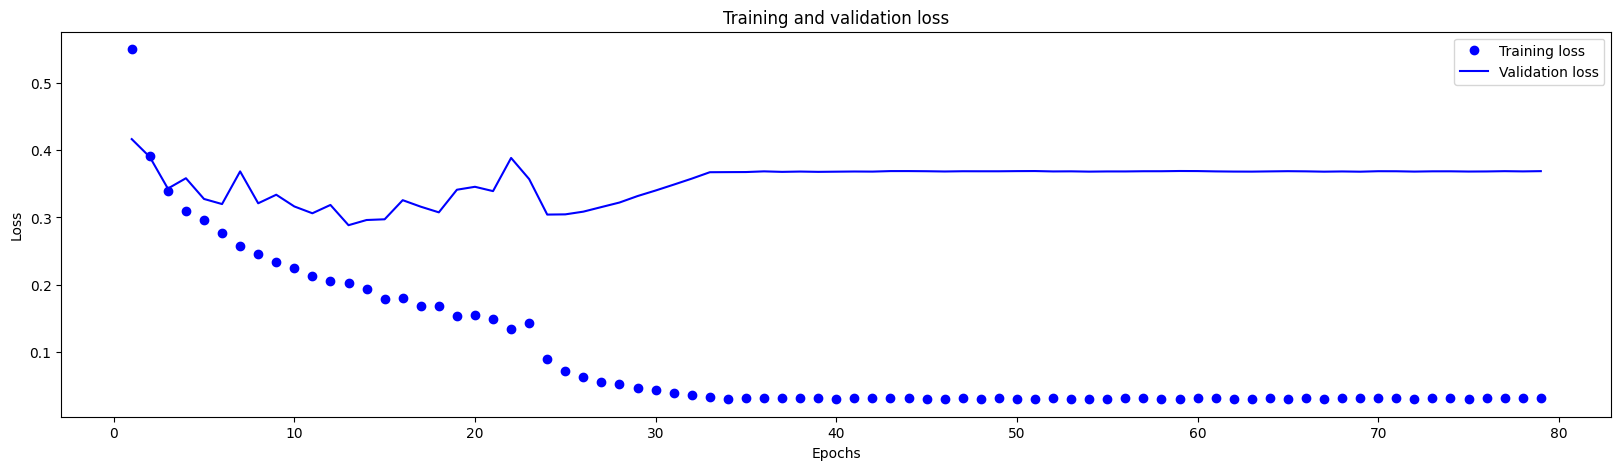

In [ ]:
history_clf_dict = history_clf1.history
loss_values = history_clf_dict["loss"]
val_loss_values = history_clf_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(20,5))
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

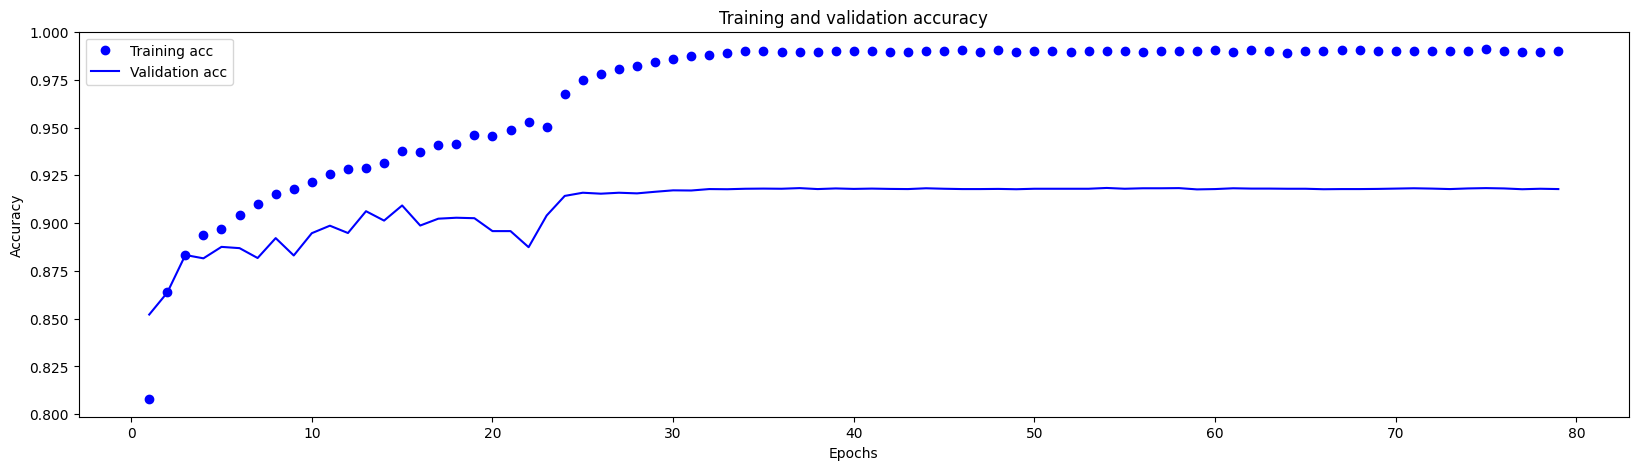

In [ ]:
acc = history_clf_dict["accuracy"]
val_acc = history_clf_dict["val_accuracy"]
plt.figure(figsize=(20,5))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
xception = tf.keras.saving.load_model('/content/drive/Shareddrives/ECEN_758_Project/xception_stable_III.h5')

In [ ]:
test_loss, test_acc, test_precision, test_recall = xception.evaluate(x_test, y_test_clf_encoded)

accuracy_score = round(test_acc*1000) / 10
precision_score = round(test_precision*1000) / 10
recall_score = round(test_recall*1000) / 10

print(f"accuracy score: {accuracy_score}")
print(f"precison score: {precision_score}")
print(f"recall score: {recall_score}")

313/313 [==============================] - 44s 137ms/step - loss: 0.3915 - accuracy: 0.9153 - precision: 0.9192 - recall: 0.9141
accuracy score: 91.5
precison score: 91.9
recall score: 91.4


In [ ]:
xception_test_proba = xception.predict(x_test)
xception_test_labels = []
for i in range(len(xception_test_proba)):
  xception_test_label = np.argmax(xception_test_proba[i])
  xception_test_labels.append(xception_test_label)
# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_predTest, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

# print(classification_report(y_test, xception_test_labels))

313/313 [==============================] - 38s 119ms/step


In [ ]:
print(classification_report(y_test, xception_test_labels))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.89      0.87      0.88      1000
           3       0.90      0.92      0.91      1000
           4       0.86      0.89      0.87      1000
           5       0.98      0.98      0.98      1000
           6       0.76      0.75      0.76      1000
           7       0.96      0.97      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
'''06'''
with open (basepath + '/randomForestClassifier06.pkl', 'rb') as file1:
  randomforest06 = pickle.load(file1)

'''26'''
with open (basepath + '/randomForestClassifier26.pkl', 'rb') as file2:
  randomforest26 = pickle.load(file2)

'''46'''
with open (basepath + '/xgboost46.pkl', 'rb') as file3:
  xgboost46 = pickle.load(file3)

'''24'''
with open (basepath + '/randomForestClassifier24.pkl', 'rb') as file4:
  randomforest24 = pickle.load(file4)

In [ ]:
xception_test_labels_topII = {}
for i in range(len(xception_test_proba)):
  xception_test_label_topII = np.argpartition(xception_test_proba[i], -2)[-2:]
  # print(xception_test_label_topII)
  xception_test_labels_topII.update({i: xception_test_label_topII})
  #break

allLabels = list(xception_test_labels_topII.values())
keys_topII = list(xception_test_labels_topII.keys())
allLabels = np.array(allLabels)
keys_topII = np.array(keys_topII)

indices06 = []
indices26 = []
indices46 = []
indices24 = []

for i in range(len(allLabels)):

  if np.array_equal(allLabels[i], [0, 6]) == True or np.array_equal(allLabels[i], [6, 0]) == True:
    indices06.append(i)
  elif np.array_equal(allLabels[i], [2, 6]) == True or np.array_equal(allLabels[i], [6, 2]) == True:
    indices26.append(i)
  elif np.array_equal(allLabels[i], [4, 6]) == True or np.array_equal(allLabels[i], [6, 4]) == True:
    indices46.append(i)
  else:
    indices24.append(i)

samples06 = []
samples26 = []
samples46 = []
samples24 = []

for j in indices06:
  samples06.append(X_test_rf[j])

for k in indices26:
  samples26.append(X_test_rf[k])

for l in indices46:
  samples46.append(X_test_rf[l])

for m in indices24:
  samples24.append(X_test_rf[m])

In [ ]:
labels06 = []
labels26 = []
labels46 = []
labels24 = []
for j in indices06:
  labels06.append(y_test_clf_encoded[j])

for k in indices26:
  labels26.append(y_test_clf_encoded[k])

for l in indices46:
  labels46.append(y_test_clf_encoded[l])

for m in indices24:
  labels24.append(y_test_clf_encoded[m])

In [ ]:
pred_rf_06 = randomforest06.predict(samples06)
print(classification_report(labels06, pred_rf_06))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       458
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00         0
           6       0.76      0.65      0.70       368
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1

   micro avg       0.75      0.75      0.75       868
   macro avg       0.15      0.15      0.15       868
weighted avg       0.71      0.75      0.73       868
 samples avg       0.75      0.75      0.75       868



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_rf_26 = randomforest26.predict(samples26)
print(classification_report(labels26, pred_rf_26))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00         0
           2       0.82      0.94      0.88       403
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        19
           5       0.00      0.00      0.00         0
           6       0.64      0.54      0.58       138
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0

   micro avg       0.78      0.78      0.78       580
   macro avg       0.15      0.15      0.15       580
weighted avg       0.72      0.78      0.75       580
 samples avg       0.78      0.78      0.78       580



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_xgb_46 = xgboost46.predict(samples46)
print(classification_report(labels46, pred_xgb_46))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         5
           4       0.79      0.83      0.81       327
           5       0.00      0.00      0.00         0
           6       0.84      0.84      0.84       384
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0

   micro avg       0.82      0.80      0.81       738
   macro avg       0.16      0.17      0.16       738
weighted avg       0.79      0.80      0.79       738
 samples avg       0.77      0.80      0.78       738



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
pred_rf_24 = randomforest24.predict(samples24)
print(classification_report(labels24, pred_rf_24))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       520
           1       0.00      0.00      0.00       998
           2       0.37      0.90      0.53       566
           3       0.00      0.00      0.00       975
           4       0.00      0.00      0.00       649
           5       0.00      0.00      0.00      1000
           6       0.01      0.76      0.03       110
           7       0.00      0.00      0.00      1000
           8       0.00      0.00      0.00       997
           9       0.00      0.00      0.00       999

   micro avg       0.08      0.08      0.08      7814
   macro avg       0.04      0.17      0.06      7814
weighted avg       0.03      0.08      0.04      7814
 samples avg       0.08      0.08      0.08      7814



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Achieved the same metrics without pipeline | So, not required anymore

In [ ]:
xgboost = XGBClassifier(n_estimators=35, max_depth=15, learning_rate=1, device="cuda")

In [ ]:
xgboost.fit(X_train_rf, y_train_clf)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=35, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
filename = 'xgboost.pkl'
pickle.dump(xgboost,  open(filename, 'wb'))

In [ ]:
xgboostStable = pickle.load(open('/content/drive/Shareddrives/ECEN_758_Project/xgboost.pkl', 'rb'))

In [ ]:
y_val_rf = xgboostStable.predict(X_val_rf)
xgboost_val_proba = xgboostStable.predict_proba(X_test_rf)

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_val_rf, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

print(classification_report(y_val_clf, y_val_rf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1202
           1       0.99      0.98      0.99      1219
           2       0.82      0.85      0.84      1205
           3       0.88      0.93      0.90      1184
           4       0.82      0.85      0.84      1202
           5       0.98      0.97      0.97      1211
           6       0.77      0.65      0.70      1218
           7       0.95      0.96      0.96      1159
           8       0.97      0.97      0.97      1197
           9       0.96      0.97      0.96      1203

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [ ]:
y_test_rf = xgboostStable.predict(X_test_rf)
xgboost_test_proba = xgboostStable.predict_proba(X_test_rf)

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_predTest, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

print(classification_report(y_test, y_test_rf))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.79      0.84      0.81      1000
           3       0.89      0.92      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.63      0.68      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
def getconflicts(classifier1_labels, classifier2_labels):

  label_conflicts = np.where(np.not_equal(classifier1_labels, classifier2_labels))
  conflicts = []
  for i in label_conflicts[0]:
    conflicts.append(i)

  return conflicts, label_conflicts


def maxprobasFromCLF(classifer1probas, classifier2probas):

  maxprobas_classifier1 = []
  for i in range(len(classifer1probas)):
    maxprobas_classifier1.append(np.max(classifer1probas[i]))

  maxprobas_classifier2 = []
  for j in range(len(classifier2probas)):
    maxprobas_classifier2.append(np.max(classifier2probas[j]))

  return maxprobas_classifier1, maxprobas_classifier2


def getconflictlabels(conflictsArray, classifier1_labels, classifier2_labels):

  classifier1_coflict_labels = []
  for i in conflicts:
    classifier1_coflict_labels.append(classifier1_labels[i])

  classifier2_coflict_labels = []
  for i in conflicts:
    classifier2_coflict_labels.append(classifier2_labels[i])

  return classifier1_coflict_labels, classifier2_coflict_labels


def getconflictprobas(conflictsArray, classifier1_probas, classifier2_probas):

  classifier1_coflict_probas = []
  for i in conflicts:
    classifier1_coflict_probas.append(classifier1_probas[i])

  classifier2_coflict_probas = []
  for i in conflicts:
    classifier2_coflict_probas.append(classifier2_probas[i])

  return classifier1_coflict_probas, classifier2_coflict_probas


def finalLabelsGeneric(conflictsArray, classifier1_conflictProbas, classifier2_conflictProbas, classifier1_labels, classifier2_labels):

  xg = []
  xc = []
  xg_conflictprobas = []
  xc_conflictprobas = []

  for i in range(len(classifier1_conflictProbas)):
    if classifier1_conflictProbas[i] > classifier2_conflictProbas[i]:
      xg.append(conflictsArray[i])
      xg_conflictprobas.append(classifier1_conflictProbas[i])
    else:
      xc.append(conflictsArray[i])
      xc_conflictprobas.append(classifier2_conflictProbas[i])

  final_labels = classifier2_labels

  for i in xg:
    xg_label = classifier1_labels[i]
    final_labels[i] = xg_label

  return final_labels, xg_conflictprobas, xc_conflictprobas

In [ ]:
conflicts, _ = getconflicts(y_test_rf, xception_test_labels)
xgboost_probas, xception_probas = maxprobasFromCLF(xgboost_test_proba, xception_test_proba)
xgboost_coflict_labels, xception_coflict_labels = getconflictlabels(conflicts, y_test_rf, xception_test_labels)
xgboost_coflict_probas, xception_coflict_probas = getconflictprobas(conflicts, xgboost_probas, xception_probas)

In [ ]:
finalLabels_generic, xg_conflictprobas, xc_conflictprobas = finalLabelsGeneric(conflicts, xgboost_coflict_probas, xception_coflict_probas, y_test_rf, xception_test_labels)

In [ ]:
print(classification_report(y_test, finalLabels_generic))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.86      0.87      0.86      1000
           3       0.91      0.93      0.92      1000
           4       0.83      0.87      0.85      1000
           5       0.98      0.99      0.99      1000
           6       0.79      0.71      0.75      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
xg_conflictprobas

In [ ]:
confusingLabels = []
confusingSample = {}
for i in range(len(xception_test_labels)):

  if xception_test_labels[i] == 2 or xception_test_labels[i] == 6:
    confusingSample.update({i: x_test[i]})

In [ ]:
keys = list(confusingSample.keys())
print(np.unique(keys))
print(len(keys))

[   1    4    7 ... 9970 9971 9985]
1911


In [ ]:
keys[0:10]

[1, 4, 7, 16, 17, 20, 25, 26, 44, 46]

In [ ]:
exp_samples = list(confusingSample.values())

In [ ]:
exp_samples = np.array(exp_samples)

In [ ]:
exp_samples.shape

(1911, 28, 28)

In [ ]:
xception_specialized26_test_proba = xception_specialized26.predict(exp_samples)
xception_specialized26_test_labels = []
for i in range(len(xception_specialized26_test_proba)):
  xception_specialized26_test_label = np.argmax(xception_specialized26_test_proba[i])
  xception_specialized26_test_labels.append(xception_specialized26_test_label)

60/60 [==============================] - 0s 7ms/step


In [ ]:
xception_specialized26_test_labels[0:10]

[2, 6, 6, 2, 2, 2, 2, 6, 6, 6]

In [ ]:
count = 0
labels_finalI = xception_test_labels
for k in keys:
  if xception_specialized26_test_labels[count] == 6:
    labels_finalI[k] = xception_specialized26_test_labels[count]
  count += 1

In [ ]:
print(classification_report(y_test, labels_finalI))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.84      0.86      1000
           3       0.91      0.93      0.92      1000
           4       0.83      0.87      0.85      1000
           5       0.98      0.99      0.99      1000
           6       0.76      0.74      0.75      1000
           7       0.96      0.97      0.97      1000
           8       0.97      0.98      0.97      1000
           9       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

